In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix 
from scipy import interp, stats
from imblearn.over_sampling import ADASYN 

### TO LOAD DATA

In [2]:
# TO IMPORT CVS FILES (REGARDING FREQUENCY OF FEATURES)
all_features_list_df_lin = pd.read_csv("training_linear_all_features_list_result.csv",index_col=False)
all_features_count_df_lin = all_features_list_df_lin.stack().value_counts() # it returns a df with the frequency for each features

In [3]:
# TO IMPORT CVS FILE AND CREATE A PD DATAFRAME WITH ONLY THE FIRST n SELECTED FEATURES - TRAINING DATASET

first_n_features_to_select_lin = 5 # choose the value

# load the original dataset
training_dataframe_df_lin = pd.read_csv("training - linear after WEKA CfsSubsetEval.csv",index_col='exam')
size_mapping = {"codeletion":0,"noncodeletion":1} # MAPPING for outcome 
training_dataframe_df_lin["outcome"] = training_dataframe_df_lin["outcome"].map(size_mapping)

training_feature_names_lin = [x[2:-2] for x in [*all_features_count_df_lin.index]]
training_selected_features_lin = training_feature_names_lin[:first_n_features_to_select_lin]
training_New_dataframe_lin = training_dataframe_df_lin[training_selected_features_lin]
training_New_dataframe_lin["outcome"] = training_dataframe_df_lin["outcome"] 
training_dataframe_with_selected_features_df_lin = training_New_dataframe_lin

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [5]:
# TO IMPORT CVS FILE AND CREATE A PD DATAFRAME WITH ONLY THE FIRST n SELECTED FEATURES - TESTING DATASET

first_n_features_to_select_lin = 5 # choose the value

# load the original dataset
testing_dataframe_df_lin = pd.read_csv("testing - linear.csv",index_col='exam', encoding = "ISO-8859-1") # insert the all original dataset
size_mapping = {"codeletion":0,"noncodeletion":1} # MAPPING for outcome 
testing_dataframe_df_lin["outcome"] = testing_dataframe_df_lin["outcome"].map(size_mapping)

testing_feature_names_lin = [x[3:-3] for x in [*all_features_count_df_lin.index]]
testing_selected_features_lin = testing_feature_names_lin[:first_n_features_to_select_lin]
testing_New_dataframe_lin = testing_dataframe_df_lin[testing_selected_features_lin]
testing_New_dataframe_lin["outcome"] = testing_dataframe_df_lin["outcome"]
testing_dataframe_with_selected_features_df_lin = testing_New_dataframe_lin

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [6]:
print ("The chosen features are:", [x[1:-1] for x in [*training_selected_features_lin]])

The chosen features are: ['Wavelet_LLH_Stats_median (T1)', 'Wavelet_LHL_Stats_median (T1)', 'Wavelet_LLL_IH_p10 (T1)', 'GLCM_clusShade (T1)', 'Wavelet_LHH_Fractal_lacunarity (T2)']


## Training the model on the training dataset and testing the model on validation dataset

In [7]:
model_lin = RandomForestClassifier(random_state=1, n_estimators=100) # Choose the model

In [8]:
# To rename dataframes into X_train_lin, Y_train_lin, X_test_lin, Y_test_lin (numpy arrays)

Y_train_lin = training_dataframe_with_selected_features_df_lin['outcome']
X_train_lin = training_dataframe_with_selected_features_df_lin.drop('outcome',axis=1)

Y_test_lin = testing_dataframe_with_selected_features_df_lin['outcome']
X_test_lin = testing_dataframe_with_selected_features_df_lin.drop('outcome',axis=1)

In [9]:
#StandardScaler
ss = StandardScaler() 
X_train_SS_np_lin = ss.fit_transform(X_train_lin) 
X_train_SS_lin=pd.DataFrame(X_train_SS_np_lin, index=X_train_lin.index, columns=X_train_lin.columns)
X_test_SS_np_lin = ss.transform(X_test_lin) 
X_test_SS_lin=pd.DataFrame(X_test_SS_np_lin, index=X_test_lin.index, columns=X_test_lin.columns)

# ADASYN
sm = ADASYN(random_state=1)
X_train_SS_balanced_np_lin, Y_train_balanced_np_lin = sm.fit_sample(X_train_SS_lin, Y_train_lin)
X_train_SS_balanced_lin=pd.DataFrame(X_train_SS_balanced_np_lin, columns=X_train_SS_lin.columns)
Y_train_balanced_lin=pd.DataFrame(Y_train_balanced_np_lin, columns=["outcome"])

# Fitting the model
model_lin.fit (X_train_SS_balanced_lin, Y_train_balanced_lin)

# Compute predictions, probabilities and accuracy
predictions_lin = model_lin.predict(X_test_SS_lin)
probabilities_lin = model_lin.predict_proba(X_test_SS_lin)
accuracy_lin = accuracy_score(Y_test_lin, predictions_lin)

# Compute AUC
fpr_lin, tpr_lin, threshold_lin = roc_curve(Y_test_lin, np.array(probabilities_lin)[:,1])
roc_auc_lin = auc(fpr_lin, tpr_lin)

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [10]:
# Rename the values for bootstrap code and De-Long test
y_true_lin = np.array(Y_test_lin)
y_pred_lin = np.array(predictions_lin)
y_prob_lin = np.array(probabilities_lin)[:,1]

In [11]:
# print Confusion Matrix
print ("Confusion matrix for linear features: \n", confusion_matrix(y_true_lin, y_pred_lin))

Confusion matrix for linear features: 
 [[21  4]
 [10 15]]


In [12]:
# Perform BOOTSTRAP with y_true, predictions, probabilities

n_bootstraps = 10000
rng_seed = 1  # control reproducibility

bootstrapped_acc_lin = []
bootstrapped_auc_lin = []
bootstrapped_sens_lin = []
bootstrapped_spec_lin = []

bootstrapped_tpr_lin = []
bootstrapped_fpr_lin = []
bootstrapped_thr_lin = []

bootstrapped_tprs_lin = []

mean_fpr = np.linspace(0, 1, 100)

rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices_0=np.where(y_true_lin == 0)
    indices_1=np.where(y_true_lin == 1)
    
    # 'balanced bootstrapping'
    random_indices_0=rng.choice(indices_0[0],len(indices_0[0]))
    random_indices_1=rng.choice(indices_1[0],len(indices_0[0]))
    random_indices=np.concatenate((random_indices_0,random_indices_1), axis=None)

    acc_lin = accuracy_score(y_true_lin[random_indices], y_pred_lin[random_indices])
    auc_lin = roc_auc_score(y_true_lin[random_indices], y_prob_lin[random_indices])
    sens_lin = recall_score(y_true_lin[random_indices], y_pred_lin[random_indices], pos_label=1)
    spec_lin = recall_score(y_true_lin[random_indices], y_pred_lin[random_indices], pos_label=0)
    
    fpr_lin, tpr_lin, threshold_lin = roc_curve(y_true_lin[random_indices], y_prob_lin[random_indices])
    
    interp_tpr_lin = interp(mean_fpr, fpr_lin, tpr_lin)
    interp_tpr_lin[0] = 0.0
    bootstrapped_tprs_lin.append(interp_tpr_lin)
    
    bootstrapped_acc_lin.append(acc_lin)
    bootstrapped_auc_lin.append(auc_lin)
    bootstrapped_sens_lin.append(sens_lin)
    bootstrapped_spec_lin.append(spec_lin)

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

metrics distributions for bootstrapping steps

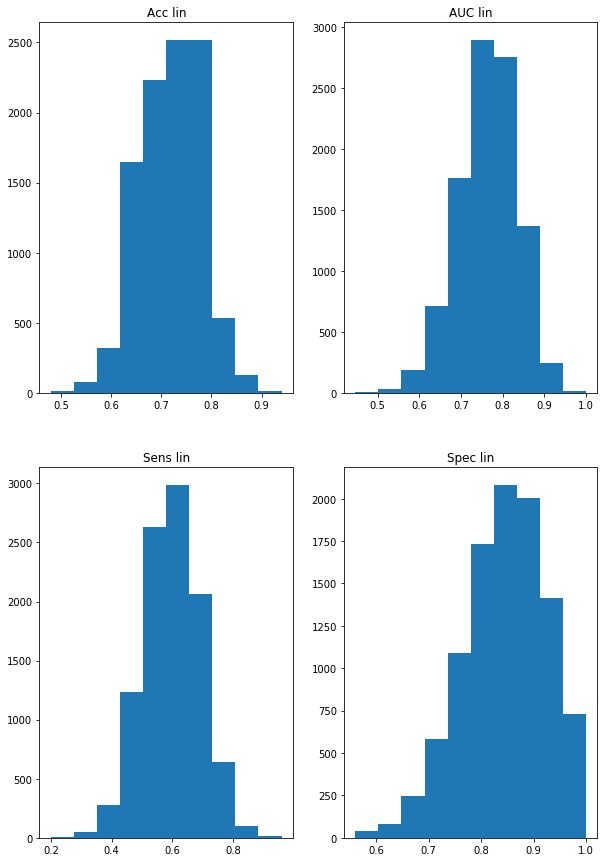

In [13]:
plt.figure(figsize=(10, 15))

plt.subplot(2,2,1)
plt.hist(bootstrapped_acc_lin)
plt.title('Acc lin')

plt.subplot(2,2,2)
plt.hist(bootstrapped_auc_lin)
plt.title('AUC lin')

plt.subplot(2,2,3)
plt.hist(bootstrapped_sens_lin)
plt.title('Sens lin')

plt.subplot(2,2,4)
plt.hist(bootstrapped_spec_lin)
plt.title('Spec lin')

plt.show()

distr normality test (Shapiro-Wilcoxon)

In [14]:
print ('Acc lin: ', stats.shapiro(bootstrapped_acc_lin))
print ('AUC lin: ', stats.shapiro(bootstrapped_auc_lin))
print ('Sens lin: ', stats.shapiro(bootstrapped_sens_lin))
print ('Spec lin: ', stats.shapiro(bootstrapped_spec_lin))

Acc lin:  (0.9905468821525574, 3.1441678403200444e-25)
AUC lin:  (0.9942599534988403, 1.4113761446867792e-19)
Sens lin:  (0.9861721396446228, 4.706796742048425e-30)
Spec lin:  (0.966020405292511, 3.0828566215145976e-43)


/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values are small -> distr is not normal -> estimation should be represented as median (low_percentile, up_percentile)

In [15]:
print ('Acc lin: {} ({}, {})'.format(np.median(bootstrapped_acc_lin), np.percentile(bootstrapped_acc_lin, 2.5), np.percentile(bootstrapped_acc_lin, 97.5)))
print ('AUC lin: {} ({}, {})'.format(np.median(bootstrapped_auc_lin), np.percentile(bootstrapped_auc_lin, 2.5), np.percentile(bootstrapped_auc_lin, 97.5)))
print ('Sens lin: {} ({}, {})'.format(np.median(bootstrapped_sens_lin), np.percentile(bootstrapped_sens_lin, 2.5), np.percentile(bootstrapped_sens_lin, 97.5)))
print ('Spec lin: {} ({}, {})'.format(np.median(bootstrapped_spec_lin), np.percentile(bootstrapped_spec_lin, 2.5), np.percentile(bootstrapped_spec_lin, 97.5)))

Acc lin: 0.72 (0.6, 0.84)
AUC lin: 0.768 (0.6144000000000001, 0.8904)
Sens lin: 0.6 (0.4, 0.8)
Spec lin: 0.84 (0.68, 0.96)


## ROC CURVE AND AUC

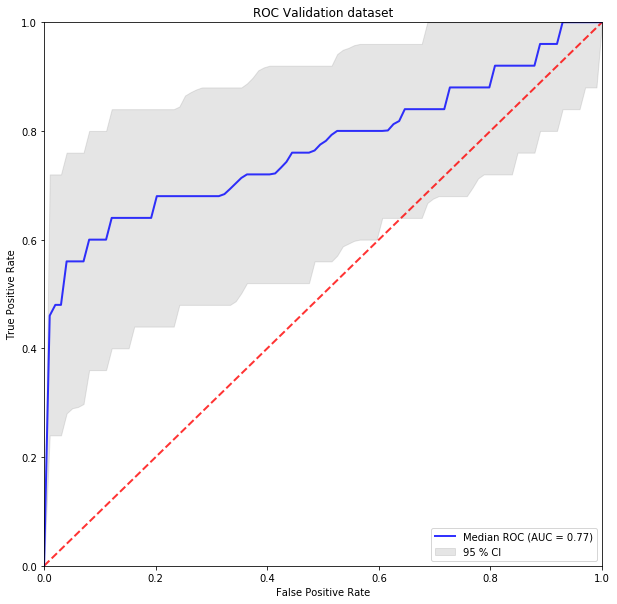

In [16]:
# ROC CURVE

fig, ax = plt.subplots(figsize=(10,10))  

plt.title('ROC Validation dataset')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr_lin = np.median(bootstrapped_tprs_lin, axis=0)  
mean_tpr_lin[-1] = 1.0                
plt.plot(mean_fpr, mean_tpr_lin, color='b', 
        label=r'Median ROC (AUC = %0.2f)' % (np.median(bootstrapped_auc_lin)), 
        lw=2, alpha=.8)

tprs_upper = np.percentile(bootstrapped_tprs_lin, 2.5,  axis = 0)
tprs_lower = np.percentile(bootstrapped_tprs_lin, 97.5, axis = 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='95 % CI')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend(loc="lower right")
plt.show()